# pyRadiomics feature visualization using multi-dimensional scaling and heatmaps

pyRadiomics features can be used to classify and group images.  Three techniques will be demonstrated, multi-dimensional scaling for visual grouping of datasets, heatmaps to show correlations between features, and a clustermap to show hierarchial clustering of features.

For more detailed examples and links to source code, visit http://radiomics.io

In this example, we will download and process data provided by [Brigham and Women's Surgical Planning Lab](https://www.spl.harvard.edu/).  The data has kindly been made available by the SPL to support reproducible science.

> Kaus M.R., Warfield S.K., Nabavi A., Black P.M., Jolesz F.A., Kikinis R. Automated Segmentation of Brain Tumors. SPL 2007 Dec http://www.spl.harvard.edu/publications/item/view/1180

> Michael Kaus, Simon K. Warfield, Arya Nabavi, Peter M. Black, Ferenc A. Jolesz, and Ron Kikinis. Automated Segmentation of MRI of Brain Tumors.
Radiology. 2001 Feb;218(2):586-91. http://www.spl.harvard.edu/publications/item/view/169

> Simon K. Warfield, Michael Kaus, Ferenc A. Jolesz, and Ron Kikinis. Adaptive, Template Moderated, Spatially Varying Statistical Classification. Med Image Anal. 2000 Mar;4(1):43-55. http://www.spl.harvard.edu/publications/item/view/209


In [1]:
# Download the zip file if it does not exist
import os, zipfile
import pandas as pd
import seaborn as sns

from six.moves import urllib

url = "http://www.spl.harvard.edu/publications/bitstream/download/5270"
filename = 'example_data/Tumorbase.zip'
if not os.path.isfile(filename):
    if not os.path.isdir('example_data'):
        os.mkdir('example_data')
    print ("retrieving")
    urllib.request.urlretrieve(url, filename)
else:
    print ("file already downloaded")
    
extracted_path = 'example_data/tumorbase'
if not os.path.isdir(extracted_path):
    print ("unzipping")
    z = zipfile.ZipFile(filename)
    z.extractall('example_data')
    print ("done unzipping")

file already downloaded


In [2]:
# Import some libraries
import SimpleITK as sitk
from radiomics import featureextractor

# Extract features

Next we loop over all cases (`case_id` from 1 to 10), reading each image and label.  The label map contains a `6` at each voxel containing tumor.  The `radiomics` package expects `0` and `1`, so we need to use the `BinaryThreshold` filter to extract the right labels.

In [3]:
# Load up the segmentations, 1 to 10 and extract the features
params = os.path.join(os.getcwd(), '..', 'examples', 'exampleSettings', 'Params.yaml')

extractor = featureextractor.RadiomicsFeaturesExtractor(params)
# hang on to all our features
features = {}

for case_id in range(1,11):
    path = 'example_data/tumorbase/AutomatedSegmentation/case{}/'.format(case_id)
    image = sitk.ReadImage(path + "grayscale.nrrd")
    label = sitk.ReadImage(path + "segmented.nrrd")
    # Tumor is in label value 6, make a binary mask
    label = sitk.BinaryThreshold(label, 6, 6)
    features[case_id] = extractor.execute ( image, label )
    

# A list of the valid features, sorted
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), features[1] )))

In [4]:
# Make a numpy array of all the values
import numpy as np

samples = np.zeros((10,len(feature_names)))
for case_id in range(1,11):
    a = np.array([])
    for feature_name in feature_names:
        a = np.append(a, features[case_id][feature_name])
    samples[case_id-1,:] = a
    
# May have NaNs
samples = np.nan_to_num(samples)

# Multidimensional scaling

[Multidimensional scaling or MDS](https://en.wikipedia.org/wiki/Multidimensional_scaling) is as way to visualize very high dimensional data in a lower dimensional space.  In our case, the feature space is `len(feature_names)` (or 93) dimensional space.  To help us understand the data, we project into 2d space.  MDS preserves the relative distance between sample points during the projection, so two samples close together in 2d space would also be close together in the original 93-dimensional space (and *vice versa*).

We us non-metric algorithm, because our data are highly non uniform in the scale of each feature.

In [5]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

similarities = euclidean_distances(samples)


seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=5000, eps=1e-12, random_state=seed,
                   n_init=10,
                   dissimilarity="precomputed", n_jobs=1, metric=False)
pos = mds.fit_transform(similarities)

# Plot

Here we use the results.  **NB:** there are two points in the "green-ish" colored circle in the center of the plot.

Looking over our features, it's likely that meningioma and astrocytoma could be distinguisted by a classifier (based on our rather limited data set), but, in at least one case, glioma and astrocytoma features are relatively close together.

c:\python27\lib\site-packages\ipykernel\__main__.py:24: RuntimeWarning: divide by zero encountered in divide


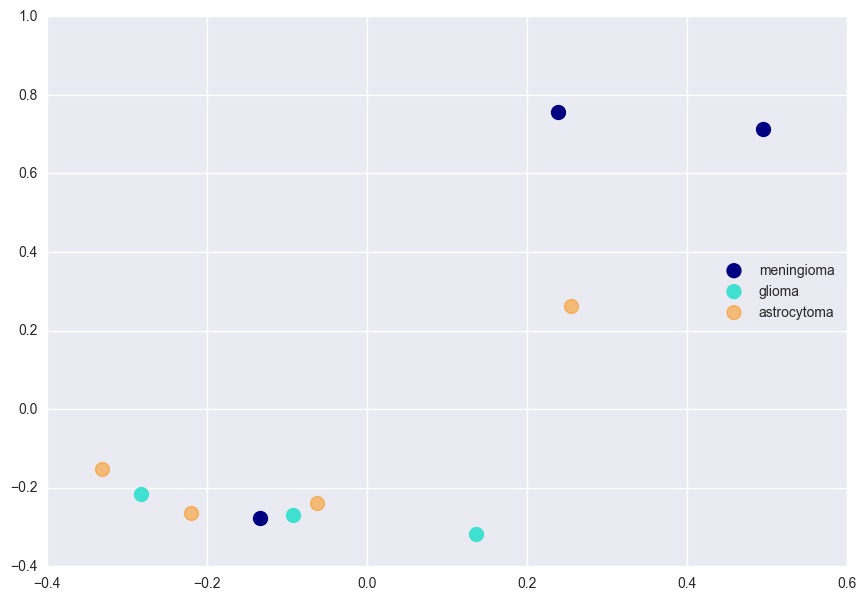

In [6]:
# Plot

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm


fig = plt.figure(1)
ax = plt.axes([0., 0., 1., 1.])

s = 100

# Type of tumor
meningioma = [0, 1, 2]
glioma = [3,5,9]
astrocytoma = [4, 6, 7, 8]

plt.scatter(pos[meningioma, 0], pos[meningioma, 1], color='navy', alpha=1.0, s=s, lw=1, label='meningioma')
plt.scatter(pos[glioma, 0], pos[glioma, 1], color='turquoise', alpha=1.0, s=s, lw=1, label='glioma')
plt.scatter(pos[astrocytoma, 0], pos[astrocytoma, 1], color='darkorange', alpha=0.5, s=s, lw=1, label='astrocytoma')

plt.legend(scatterpoints=1, loc=5, shadow=False)

similarities = similarities.max() / similarities * 100
similarities[np.isinf(similarities)] = 0
plt.show()

# Plot features as a heatmap

A heat map gives the correlation of features to each other, red indicating positive correlation, and blue negative.  A heatmap may be clustered to show groupings of features that are similar.

In [7]:
import pandas as pd
import seaborn as sns

# type of each tumor
types =['meningioma', 'meningioma', 'meningioma', 'glioma', 'astrocytoma', 'glioma', 'astrocytoma', 'astrocytoma', 'astrocytoma', 'glioma']

# Construct a pandas dataframe from the samples
d = pd.DataFrame(data=samples, columns=feature_names, index=types)

corr = d.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True)

# Cluster the heatmap

Though useful, heatmaps tell a much better story if the features are clustered.  Here we take a smaller subset of the features and cluster.  In the [dendrogram](https://en.wikipedia.org/wiki/Dendrogram), there are 2 major groups, and many smaller groupings based on features. 

In [8]:
# Choose a subset of features for clustering
dd = d.iloc[:,1:50]

# sns.clustermap(d, linewidths=.5, figsize=(13,13))
m = d.as_matrix()

from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(m,'ward')

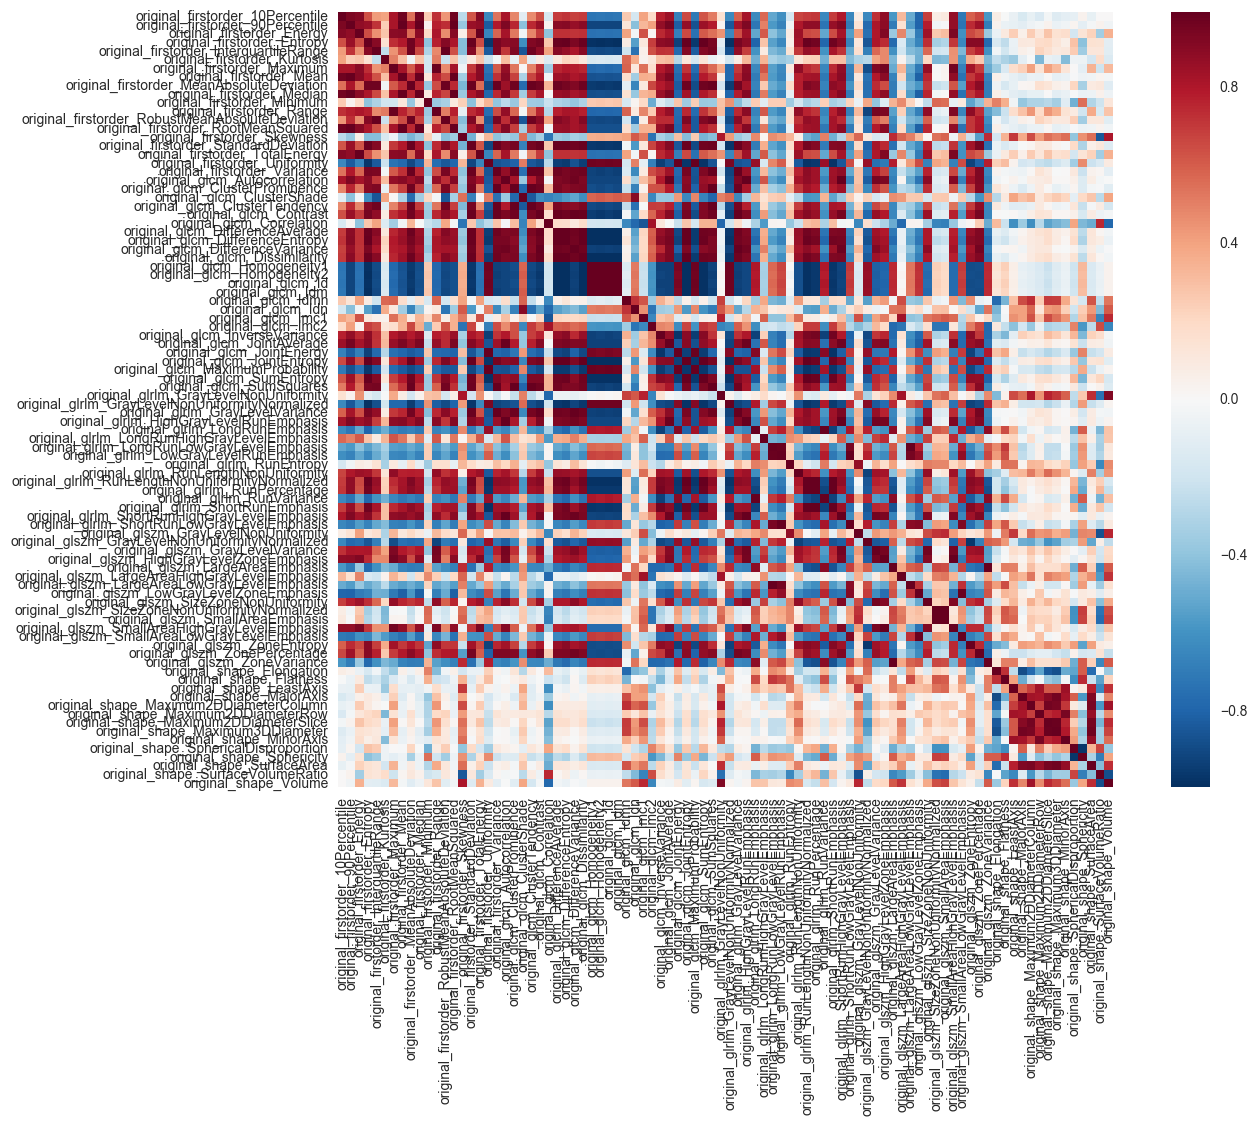

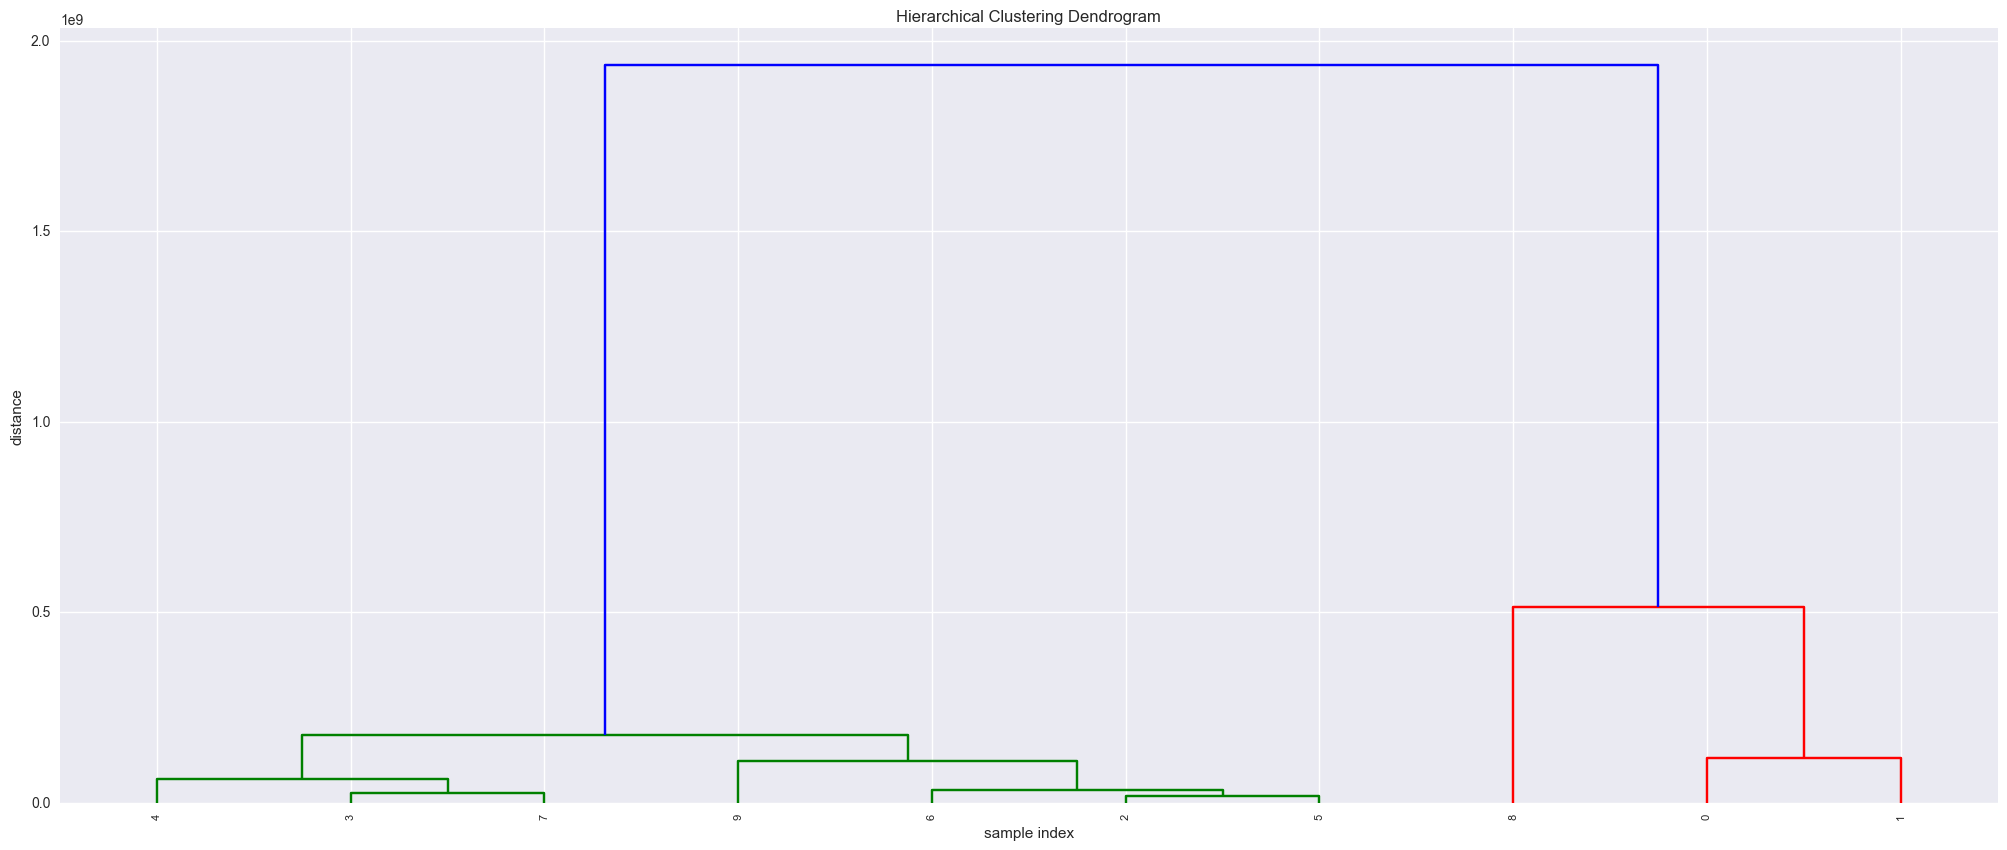

In [9]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [10]:
d.head()

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MinorAxis,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_Volume
meningioma,140.0,175.0,703288387.0,1.407119,18.0,5.772689,291.0,156.770410,10.982513,155.0,...,50.784817,44.244041,57.463473,57.961767,38.979460,1.511811,0.661458,8178.794758,0.218589,37416.357422
meningioma,150.0,204.0,773687995.0,2.111630,20.0,9.286318,458.0,176.417046,18.328115,177.0,...,52.585644,44.522466,51.978436,52.993551,34.207775,1.616101,0.618773,7857.842034,0.246477,31880.566406
meningioma,47.0,67.0,78040812.0,0.842528,10.0,5.565444,124.0,57.087513,6.358937,57.0,...,47.723815,40.476121,45.282318,49.536918,36.263599,1.413562,0.707433,6733.261085,0.217814,30912.890625
glioma,39.0,57.0,47124084.0,0.974351,10.0,5.640700,104.0,47.435372,5.806231,47.0,...,44.384858,45.188667,43.012762,45.921809,34.663747,1.514442,0.660309,6577.901286,0.244378,26916.943359
astrocytoma,89.0,122.0,22154132.0,1.296074,16.0,7.692408,135.0,105.548354,11.158143,108.0,...,22.631646,22.945588,22.539029,25.862089,19.495527,1.738603,0.575175,1574.603483,0.614386,2562.890625


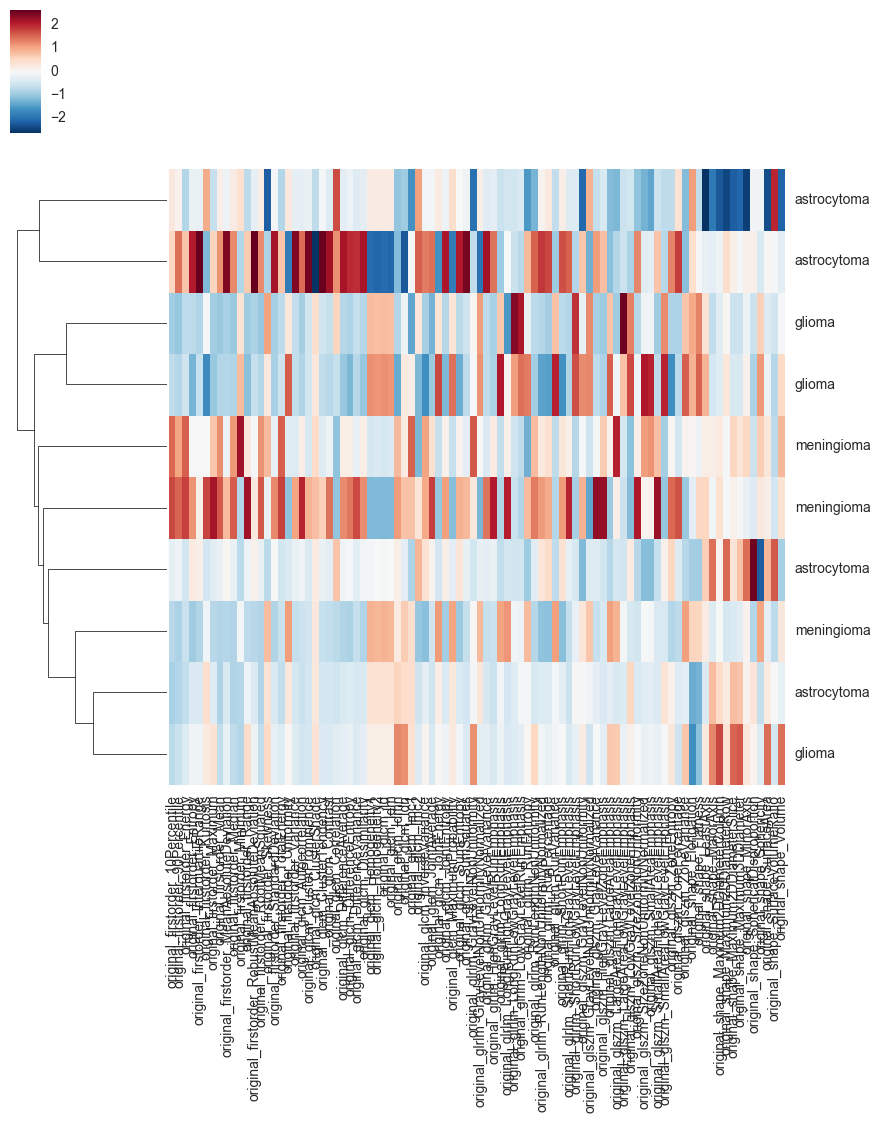

In [11]:
pp = sns.clustermap(d, col_cluster=False, metric='chebyshev', z_score=1)
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()